# IIE4123 HW2
## Kichang Lee(2019193016), School of Integrated Technology, Yonsei Univ

Language : Python3(Python 3.9.7 64-bit)

OS : Microsoft Windows 10 Education (10.0.19042)

Environment

CPU : Intel(R) Core(TM) i9-10850K CPU 3.60GHz, 3600Mhz, 10 Core with Intel(R) UHD Graphics 630

RAM : 64GB

GPU : RTX3090

## Notes about Task3

I used a model with sigmoid function that I used in task2 but with out the batch normalization.

(a) One with the preprocessing works better. In all the aspect of loss value and accuracy also the learning speed.

(b) The rescaled data heps the model to learn better than one with the integer value. Preprocessing let the model to treat all the images in the same manner and let them contiributes more evenly to the total loss.


# Import Packages

In [1]:
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

# Hyper-Parameters

In [2]:
BATCH_SIZE = 100
LEARNING_RATE = 0.001
EPOCHS = 50


USE_CUDA = torch.cuda.is_available() 
DEVICE = torch.device("cuda" if USE_CUDA else "cpu") 
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cuda


# Data Management

In [3]:
transform = transforms.Compose([transforms.ToTensor()]) # Rescaled into [0,1]

whole_train_set = dset.MNIST("./MNIST_data", train=True, transform=transform, download=False)
mnist_test = dset.MNIST("./MNIST_data", train=False, transform=transform, download=False)

mnist_train, mnist_val = train_test_split(whole_train_set, test_size = 0.1, stratify=whole_train_set.targets)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

C:\Users\Kichang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Model

In [4]:
class MLP(nn.Module):
    def __init__(self, activation_function):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(784, 15, bias=True),
            activation_function
        )
        self.layer2 = nn.Sequential(
            nn.Linear(15, 12, bias=True),
            activation_function
        )
        self.layer3 = nn.Sequential(
            nn.Linear(12, 12, bias=True),
            activation_function
        )
        self.layer4 = nn.Sequential(
            nn.Linear(12, 10, bias=True),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        x_out = self.layer3(x_out)        
        x_out = self.layer4(x_out)
        return x_out
        
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)
        nn.init.constant_(m.bias, 0)


In [5]:
models = [ MLP(nn.Sigmoid()).apply(weights_init).to(DEVICE), MLP(nn.Sigmoid()).apply(weights_init).to(DEVICE) ]#MLP(nn.ReLU()).apply(weights_init).to(DEVICE), MLP(nn.Sigmoid()).apply(weights_init).to(DEVICE)]
criterion = nn.CrossEntropyLoss().to(DEVICE)

In [6]:
LOSSES_TRAIN, LOSSES_VAL, LOSSES_TEST = [[] for idx in range(len(models))], [[] for idx in range(len(models))], [[] for idx in range(len(models))]
ACCS_VAL, ACCS_TEST = [[] for idx in range(len(models))], [[] for idx in range(len(models))]

GRAD_MAG = [[] for idx in range(len(models))]

for model_idx, model in enumerate(models):
    dict_param = dict()
    for name, params in model.named_parameters():
        dict_param[name] = []
    GRAD_MAG[model_idx] = dict_param

In [7]:
for model_idx, model in enumerate(models):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_sample_num = len(train_loader)
    val_sample_num = len(val_loader)

    start = time.time()
    for epoch in tqdm(range(EPOCHS), desc="EPOCHS"):
        model.train()
        LOSS_TRACE_FOR_TRAIN, LOSS_TRACE_FOR_VAL, LOSS_TRACE_FOR_TEST = [], [], []
        for idx, batch in enumerate(train_loader):
            optimizer.zero_grad()
            
            if model_idx == 0:
                X_train, Y_train = batch[0]*255, batch[1]
            else:
                X_train, Y_train = batch
            X_train, Y_train = X_train.to(DEVICE), Y_train.to(DEVICE)

            Y_pred_train = model(X_train)
            Y_train = Y_train.squeeze(-1)

            LOSS_train = criterion(Y_pred_train, Y_train)

            LOSS_TRACE_FOR_TRAIN.append(LOSS_train.cpu().detach().numpy())
            LOSS_train.backward()
            optimizer.step()
            # for name, params in model.named_parameters():
            #     if type(params.grad) != None:
            #         GRAD_MAG[model_idx][name].append(((sum(sum((params.grad**2)**0.5))/params.numel()).cpu().detach().numpy() if len(params.size()) == 2 else (sum((params.grad**2)**0.5)/params.numel()).cpu().detach().numpy()))
            # #print(name, '\n', (sum(sum((params.grad**2)**0.5))/params.numel() if len(params.size()) == 2 else sum((params.grad**2)**0.5)/params.numel()), '\n')

        with torch.no_grad():
            model.eval()

            Result_pred_val, Result_anno_val = [], []
            for idx, batch in enumerate(val_loader):
                if model_idx == 0:
                    X_val, Y_val = batch[0]*255, batch[1]
                else:
                    X_val, Y_val = batch
                X_val, Y_val = X_val.to(DEVICE), Y_val.to(DEVICE)

                Y_pred_val = model(X_val)
                Y_val = Y_val.squeeze(-1)
                LOSS_val = criterion(Y_pred_val, Y_val)

                LOSS_TRACE_FOR_VAL.append(LOSS_val.cpu().detach().numpy())

                Y_pred_val_np  = Y_pred_val.to('cpu').detach().numpy()
                Y_pred_val_np  = np.argmax(Y_pred_val_np, axis=1).reshape(-1, 1)
                Y_val_np       = Y_val.to('cpu').detach().numpy().reshape(-1, 1)

                Result_pred_val.append(list(Y_pred_val_np[0]))
                Result_anno_val.append(list(Y_val_np[0]))
            
            Result_pred_test, Result_anno_test = [], []
            for idx, batch in enumerate(test_loader):
                if model_idx == 0:
                    X_test, Y_test = batch[0]*255, batch[1]
                else:
                    X_test, Y_test = batch
                X_test, Y_test = X_test.to(DEVICE), Y_test.to(DEVICE)

                Y_pred_test = model(X_test)
                Y_test = Y_test.squeeze(-1)
                test_loss = criterion(Y_pred_test, Y_test)

                LOSS_TRACE_FOR_TEST.append(LOSS_val.cpu().detach().numpy())

                Y_pred_test_np  = Y_pred_test.to('cpu').detach().numpy()
                Y_pred_test_np  = np.argmax(Y_pred_test_np, axis=1).reshape(-1, 1)
                Y_test_np       = Y_test.to('cpu').detach().numpy().reshape(-1, 1)
                
                Result_pred_test.append(list(Y_pred_test_np[0]))
                Result_anno_test.append(list(Y_test_np[0]))

            ACC_VAL        = metrics.accuracy_score(Result_anno_val, Result_pred_val)
            ACC_TEST       = metrics.accuracy_score(Result_anno_test, Result_pred_test)

            AVG_LOSS_TRAIN = np.average(LOSS_TRACE_FOR_TRAIN)
            AVG_LOSS_VAL   = np.average(LOSS_TRACE_FOR_VAL)
            AVG_LOSS_TEST  = np.average(LOSS_TRACE_FOR_TEST)

            LOSSES_TRAIN[model_idx].append(AVG_LOSS_TRAIN)
            LOSSES_VAL[model_idx].append(AVG_LOSS_VAL)
            LOSSES_TEST[model_idx].append(AVG_LOSS_TEST)
            ACCS_VAL[model_idx].append(ACC_VAL)
            ACCS_TEST[model_idx].append(ACC_TEST)
            print(f'(epoch {epoch + 1:03d}/{EPOCHS}) Training Loss : {AVG_LOSS_TRAIN:.5f} | Validation Loss : {AVG_LOSS_VAL:.5f} | Test Loss : {AVG_LOSS_TEST:.5f} | Validation Accuracy : {ACC_VAL*100:.2f} % | Test Accyracy : {ACC_TEST*100:.2f} %')
            
    end = time.time()
    print(f"Training took {end-start:.2f} sec")
    

EPOCHS:   0%|          | 0/50 [00:00<?, ?it/s]

(epoch 001/50) Training Loss : 2.27265 | Validation Loss : 2.24083 | Test Loss : 2.23235 | Validation Accuracy : 6.67 % | Test Accyracy : 10.00 %
(epoch 002/50) Training Loss : 2.22853 | Validation Loss : 2.21912 | Test Loss : 2.20991 | Validation Accuracy : 6.67 % | Test Accyracy : 10.00 %
(epoch 003/50) Training Loss : 2.21506 | Validation Loss : 2.21080 | Test Loss : 2.20176 | Validation Accuracy : 20.00 % | Test Accyracy : 21.00 %
(epoch 004/50) Training Loss : 2.20943 | Validation Loss : 2.20689 | Test Loss : 2.19783 | Validation Accuracy : 20.00 % | Test Accyracy : 22.00 %
(epoch 005/50) Training Loss : 2.20653 | Validation Loss : 2.20478 | Test Loss : 2.19599 | Validation Accuracy : 20.00 % | Test Accyracy : 22.00 %
(epoch 006/50) Training Loss : 2.20482 | Validation Loss : 2.20369 | Test Loss : 2.19448 | Validation Accuracy : 20.00 % | Test Accyracy : 22.00 %
(epoch 007/50) Training Loss : 2.20368 | Validation Loss : 2.20241 | Test Loss : 2.19345 | Validation Accuracy : 20.00 %

EPOCHS:   0%|          | 0/50 [00:00<?, ?it/s]

(epoch 001/50) Training Loss : 2.28549 | Validation Loss : 2.25727 | Test Loss : 2.25007 | Validation Accuracy : 6.67 % | Test Accyracy : 10.00 %
(epoch 002/50) Training Loss : 2.23695 | Validation Loss : 2.22217 | Test Loss : 2.21442 | Validation Accuracy : 6.67 % | Test Accyracy : 10.00 %
(epoch 003/50) Training Loss : 2.21614 | Validation Loss : 2.21093 | Test Loss : 2.20344 | Validation Accuracy : 11.67 % | Test Accyracy : 13.00 %
(epoch 004/50) Training Loss : 2.20897 | Validation Loss : 2.20654 | Test Loss : 2.19911 | Validation Accuracy : 20.00 % | Test Accyracy : 21.00 %
(epoch 005/50) Training Loss : 2.20575 | Validation Loss : 2.20433 | Test Loss : 2.19698 | Validation Accuracy : 20.00 % | Test Accyracy : 22.00 %
(epoch 006/50) Training Loss : 2.20404 | Validation Loss : 2.20310 | Test Loss : 2.19562 | Validation Accuracy : 20.00 % | Test Accyracy : 22.00 %
(epoch 007/50) Training Loss : 2.20286 | Validation Loss : 2.20234 | Test Loss : 2.19461 | Validation Accuracy : 20.00 %

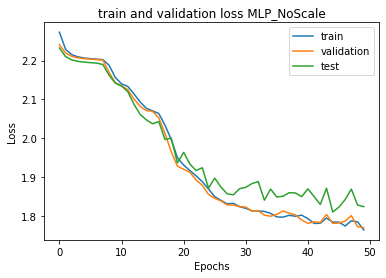

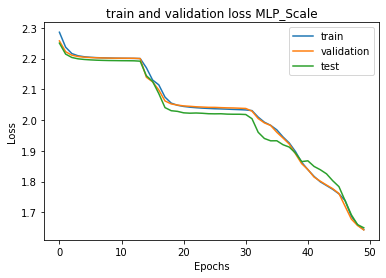

In [8]:
model_name = ['MLP_NoScale', 'MLP_Scale']
for i in range(len(models)):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('train and validation loss '+model_name[i])
    plt.plot(LOSSES_TRAIN[i], label = 'train')
    plt.plot(LOSSES_VAL[i], label = 'validation')
    plt.plot(LOSSES_TEST[i], label = 'test')
    plt.legend()
    plt.show()

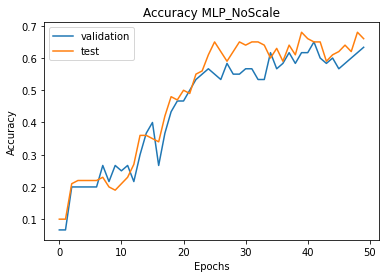

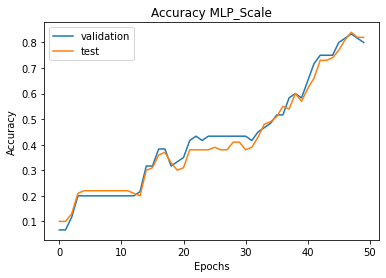

In [9]:
for i in range(len(models)):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    #plt.ylim((0.7,1))
    plt.title('Accuracy '+model_name[i])
    plt.plot(ACCS_VAL[i], label = 'validation')
    plt.plot(ACCS_TEST[i], label = 'test')
    plt.legend()
plt.show()

In [10]:
# layers = ['layer1.0.weight']#, 'layer2.0.weight', 'layer3.0.weight']
# for i in range(2):
#     plt.ylim((0,0.001))
#     plt.xlabel('Iteration')
#     plt.ylabel('Magnitude')
#     plt.title('Sum of Magnitude of Gradient for each Iteration')#+model_name[i])
#     for layer, magnitudes in GRAD_MAG[i].items():
#         if layer in layers:
#             plt.plot(magnitudes, label = layer+' '+model_name[i])
#     plt.legend()
# plt.show()